## Основное решение задачи:

Установим необходимые библиотеки:

In [ ]:
!pip install "gymnasium[atari]" -q
!pip install "autorom[accept-rom-license]" -q
!pip install pyvirtualdisplay -q

Импорт необходимых библиотек и настройка среды:

In [ ]:
# Импорт библиотек
import gymnasium as gym
import ale_py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt
import copy
import torchvision.transforms as T
from PIL import Image
from torch.autograd import Variable
import base64
import io
import imageio
from IPython.display import HTML

# Фикс для np.bool_
np.bool_ = np.bool

# Создание среды
env = gym.make("ALE/Pong-v5", render_mode='rgb_array')

image_size = 84

Узнаем число состояний, действий и название доступных действий:

In [ ]:
state_shape = env.observation_space.shape
print('Число состояний (форма):', state_shape)
n_action = env.action_space.n
print('Число действий:', n_action)

print('Доступные действия:', env.unwrapped.get_action_meanings())

Число состояний (форма): (210, 160, 3)
Число действий: 6
Доступные действия: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


Следующий код выполняет один полный игровой эпизод (партию) в среде **Pong**, делая на каждом шаге совершенно случайные действия. Во время этой игры он "записывает" каждый кадр, сохраняя его в виде изображения в список `frames`:

In [ ]:
ACTIONS = [0, 2, 3]
n_action = 3

env.reset()
frames = []

while True:
    action = ACTIONS[random.randint(0, n_action - 1)]
    obs, reward, done, truncated, _ = env.step(action)
    prev_screen = env.render()
    frames.append(prev_screen)
    if done or truncated:
        break

Эта часть кода берет все изображения (кадры), сохраненные в списке `frames` на предыдущем шаге, и "склеивает" их в один анимированный *GIF-файл*. В результате получается видеозапись случайной игры, сохраненная под именем `gym_animation.gif`:

In [ ]:
path = './gym_animation.gif'
imageio.mimsave(path, frames, fps=30, loop=0)

Напишем функцию `show_video` для отображения *GIF-файла* в среде **Google Colab**:

In [ ]:
def show_video(path):
    """
    Отображает GIF-файл в Google Colab
    @param path: путь к файлу
    """
    video = io.open(path, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

Воспользуемся функцией `show_video` для воспроизведения *GIF-файла*:


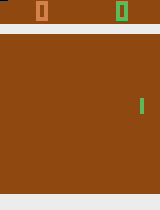

In [ ]:
show_video(path)

Напишем код, который будет преобразовывать игровые кадры в понятный для модели формат. Для этого инициализируем переменную `transform`, в которой описываеются настройки этих преобразований, а также создадим функцию `get_state`, которая применит к себе эти настройки:

In [ ]:
# Создание преобразователя, который изменяет размер и переводит в оттенки серого
transform = T.Compose([
    T.ToPILImage(), # Конвертация в формат PIL Image
    T.Grayscale(num_output_channels=1), # Преобразование в одноканальное серое изображение
    T.Resize((image_size, image_size), interpolation=Image.BICUBIC), # Изменение размера
    T.ToTensor(), # Преобразование в тензор PyTorch
])

# Функция преобразования кадра в состояние (тензор)
def get_state(obs):
    state = obs.transpose((2, 0, 1))
    state = torch.from_numpy(state)
    state = transform(state).unsqueeze(0)
    return state

state = get_state(obs)
print(state.shape)

torch.Size([1, 1, 84, 84])


Определим класс `NNModel`, в котором опишем архитектуру модели, которая будет состоять только из полносвязных слоев `Linear`:

In [ ]:
class NNModel(nn.Module):
    def __init__(self, n_action):
        super(NNModel, self).__init__()
        # Входной размер: 84 * 84 = 7056
        self.fc1 = nn.Linear(image_size * image_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.out = nn.Linear(128, n_action)

    def forward(self, x):
        # Распрямляем входной тензор из (batch_size, 1, 84, 84) в (batch_size, 7056)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = self.out(x)
        return output

В следующем коде содержится класс `DQN`, который управляет процессом обучения. Он включает в себя основную и целевую нейронные сети, оптимизатор, а также методы для предсказания, обучения на основе прошлого опыта (replay) и синхронизации сетей:

In [ ]:
class DQN():
    def __init__(self, n_action, lr=0.001):
        self.criterion = torch.nn.MSELoss()
        self.model = NNModel(n_action)
        self.model_target = copy.deepcopy(self.model)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    # Метод для синхронизации весов целевой и предсказательной сетей
    def copy_target(self):
        self.model_target.load_state_dict(self.model.state_dict())

    # Метод обучения, который обновляет нейронную сеть, получив новый пример
    def update(self, s, y):
        """
        Обновляет веса DQN, получив обучающий пример
        @param s: состояние
        @param y: целевое значение
        """
        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    # Вычисление ценностей с помощью целевой сети
    def target_predict(self, s):
        """
        Вычисляет значения Q-функции состояния для всех действий
        с помощью целевой сети
        @param s: входное состояние
        @return: целевые ценности состояния для всех действий
        """
        with torch.no_grad():
            return self.model_target(torch.Tensor(s))

    # Функция предсказания ценности состояния:
    def predict(self, s):
        """
        Вычисляет значения Q-функции состояния для всех действий,
        применяя обученную модель
        @param s: входное состояние
        @return: значения Q для всех действий
        """
        with torch.no_grad():
            return self.model(torch.Tensor(s))

    # Для вычисления целевой ценности будем использовать целевую,
    # а  не предсказательную сеть:
    def replay(self, memory, replay_size, gamma):
        """
        Буфер воспроизведения совместно с целевой сетью
        @param memory: буфер воспроизведения опыта
        @param replay_size: сколько примеров использовать при каждом
        обновлении модели
        @param gamma: коэффициент обесценивания
        """
        if len(memory) >= replay_size:
            replay_data = random.sample(memory, replay_size)
            states = []
            td_targets = []
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state.tolist()[0])
                q_values = self.predict(state).tolist()[0]
                if is_done:
                    q_values[action] = reward
                else:
                    q_values_next = self.target_predict(next_state).detach()
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()
                td_targets.append(q_values)
            self.update(states, td_targets)

 Определим *ε-жадную* стратегию:

In [ ]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    """Создает ε-жадную стратегию выбора действий"""
    def policy_function(state):
        # С вероятностью epsilon выбираем случайное действие
        if random.random() < epsilon:
            return random.randint(0, n_action - 1)
        # Иначе выбираем лучшее действие по мнению сети
        else:
            q_values = estimator.predict(state)
        return torch.argmax(q_values).item()
    return policy_function

Функция `q_learning` организует весь процесс обучения агента на протяжении заданного числа эпизодов. Она использует ε-жадную стратегию для баланса между исследованием и эксплуатацией накопленного опыта:

In [ ]:
def q_learning(env, estimator, n_episode, replay_size, target_update=10, gamma=1.0, epsilon=0.1, epsilon_decay=.99):
    """
    Глубокое Q-обучение методом Double DQN с воспроизведением опыта
    @param env: имя окружающей среды Gym
    @param estimator: объект класса DQN
    @param replay_size: сколько примеров использовать при каждом
    обновлении модели
    @param target_update: через сколько эпизодов обновлять целевую сеть
    @param n_episode: количество эпизодов
    @param gamma: коэффициент обесценивания
    @param epsilon: параметр ε-жад­ной стратегии
    @param epsilon_decay: коэффициент затухания epsilon
    """
    total_reward_episode = [0] * n_episode
    ACTIONS = [0, 2, 3] # 'NOOP', 'RIGHT', 'LEFT'

    for episode in range(n_episode):
        # Периодически обновляем веса целевой сети
        if episode % target_update == 0:
            estimator.copy_target()

        # Создаем политику с текущим значением epsilon
        policy = gen_epsilon_greedy_policy(estimator, epsilon, len(ACTIONS))
        obs, _ = env.reset()
        state = get_state(obs)
        is_done = False

        while not is_done:
            # Выбираем действие согласно стратегии
            action_idx = policy(state)
            action = ACTIONS[action_idx] # Преобразуем индекс в реальное действие

            # Выполняем действие в среде
            next_obs, reward, terminated, truncated, _ = env.step(action)
            is_done = terminated or truncated

            # Суммируем награду за эпизод
            total_reward_episode[episode] += reward
            next_state = get_state(next_obs)

            # Сохраняем переход в буфер воспроизведения
            memory.append((state, action_idx, next_state, reward, is_done))

            if is_done:
                break

            # Выполняем шаг обучения на выборке из буфера
            estimator.replay(memory, replay_size, gamma)
            state = next_state

        print(f'Эпизод: {episode}, полное вознаграждение: {total_reward_episode[episode]}, epsilon: {epsilon:.4f}')
        epsilon = max(epsilon * epsilon_decay, 0.01) # Уменьшаем epsilon для постепенного перехода от исследования к эксплуатации

    return total_reward_episode

Укажем гиперпараметры для обучения агента:

In [ ]:
# Гиперпараметры обучения
n_action = 3
lr = 0.001
target_update = 20 # целевая сеть обновляется после каждых 20 эпизодов
n_episode = 35
replay_size = 64 # размер выборки из буфера воспроизведения на каждом шаге
gamma = 0.99

dqn = DQN(n_action, lr) # Инициализация агента и памяти
memory = deque(maxlen=20000)

Выполним глубокое *Q-обучение* на 35 эпизодах:

In [ ]:
# Запуск обучения
total_rewards = q_learning(env, dqn, n_episode, replay_size, target_update, gamma=gamma, epsilon=1.0, epsilon_decay=.995)

Эпизод: 0, полное вознаграждение: -21.0, epsilon: 1.0000
Эпизод: 1, полное вознаграждение: -21.0, epsilon: 0.9950
Эпизод: 2, полное вознаграждение: -21.0, epsilon: 0.9900
Эпизод: 3, полное вознаграждение: -21.0, epsilon: 0.9851
Эпизод: 4, полное вознаграждение: -21.0, epsilon: 0.9801
Эпизод: 5, полное вознаграждение: -21.0, epsilon: 0.9752
Эпизод: 6, полное вознаграждение: -18.0, epsilon: 0.9704
Эпизод: 7, полное вознаграждение: -19.0, epsilon: 0.9655
Эпизод: 8, полное вознаграждение: -19.0, epsilon: 0.9607
Эпизод: 9, полное вознаграждение: -20.0, epsilon: 0.9559
Эпизод: 10, полное вознаграждение: -20.0, epsilon: 0.9511
Эпизод: 11, полное вознаграждение: -21.0, epsilon: 0.9464
Эпизод: 12, полное вознаграждение: -20.0, epsilon: 0.9416
Эпизод: 13, полное вознаграждение: -20.0, epsilon: 0.9369
Эпизод: 14, полное вознаграждение: -20.0, epsilon: 0.9322
Эпизод: 15, полное вознаграждение: -21.0, epsilon: 0.9276
Эпизод: 16, полное вознаграждение: -21.0, epsilon: 0.9229
Эпизод: 17, полное возна

## Анализ полученных результатов:

Построим графк, отображающий полное вознаграждение на всех эпизодах:

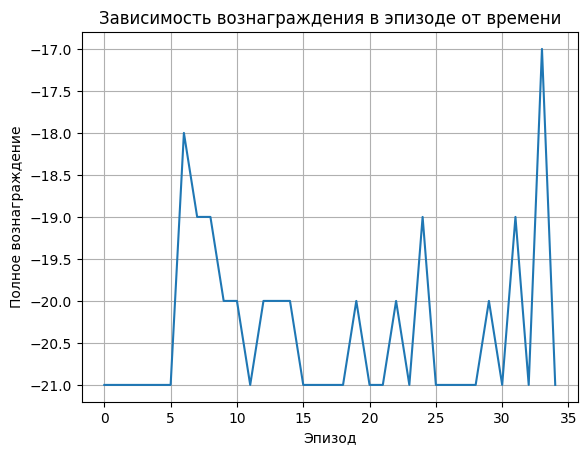

In [ ]:
# Построение графика
plt.plot(total_rewards)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.grid(True)
plt.show()

Процесс обучения находится на очень ранней стадии. Агент демонстрирует способность к обучению, о чем свидетельствуют периодические всплески производительности и достижение пикового результата в -17.0. Однако из-за высокого значения **epsilon** он все еще больше сфокусирован на исследовании среды, чем на применении накопленных знаний, что приводит к очень нестабильным результатам.

Для достижения стабильно высоких показателей требуется значительно большее количество эпизодов обучения, чтобы epsilon мог снизиться до значений, позволяющих агенту чаще выбирать лучшие действия на основе своей стратегии.

Вывод:

Для полноценного обучения необходимо хотя бы 1000 эпизодов. Однако для такого числа состояний расчеты займут несколько дней. Основная цель данного кода - демонстрация принципа работы алгоритма **DQN** на примере среды **Pong**.